In [8]:
# Data Preprocessing

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [1]:
# download data
import yfinance as yf
start_date = '2023-07-01'
end_date = '2024-07-24'
data=yf.download('NCKL.JK',start_date,end_date)
close_price_NCKL = data['Close']
close_price_NCKL_reverse = close_price_NCKL.iloc[::-1]
close_price_NCKL_reverse.reset_index(drop=True, inplace=True)

[*********************100%%**********************]  1 of 1 completed


<Axes: title={'center': 'NCKL Stock Price'}, xlabel='Time', ylabel='Close Price'>

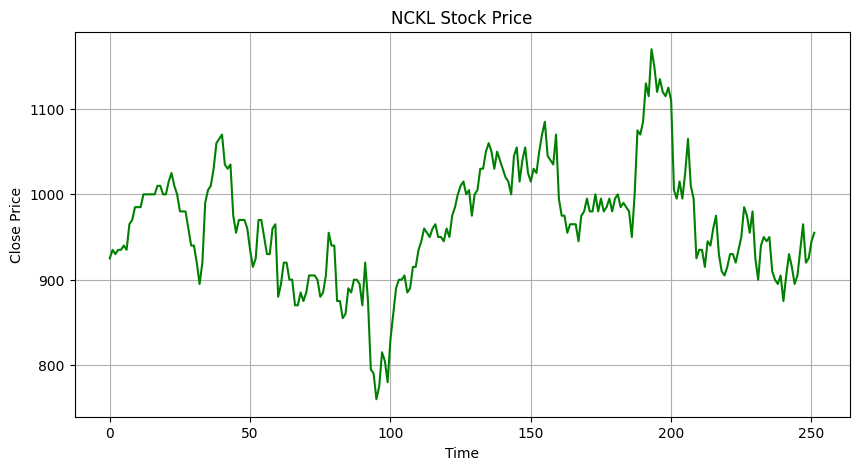

In [3]:
# membuat line chart data NCKL
close_price_NCKL_reverse.plot(xlabel='Time',ylabel='Close Price', title='NCKL Stock Price', 
                              color='g', grid=True, figsize=(10,5))

In [4]:
# Normalization
data = close_price_NCKL_reverse.values.reshape(-1, 1)  
data_normalized = data / np.max(data) 

In [5]:
# Split data 
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

In [6]:
# function untuk membuat model long Short Term Memory Network (LSTM)
def create_lstm_model(units, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(1, 1)))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [7]:
# mendefinisikan proses hyperparameter tuning
lstm_units = [50, 100, 200]
lstm_activations = ['relu', 'tanh']
learning_rates = [0.001, 0.01, 0.1]
epochs = 100
batch_size = 32

# menjalankan hyperparameter tuning untuk model LSTM
best_rmse = float('inf')
best_lstm_model = None

In [ ]:
for units in lstm_units:
    for activation in lstm_activations:
        for learning_rate in learning_rates:
            
            # Membentuk model LSTM
            model = create_lstm_model(units=units, activation=activation, learning_rate=learning_rate)
            model.fit(train_data[:-1].reshape(-1, 1, 1), train_data[1:], epochs=epochs, batch_size=batch_size, verbose=0)

            # Prediksi data
            test_predictions = model.predict(test_data[:-1].reshape(-1, 1, 1)).flatten()

            # Menghitung Root Squared Mean Error (RMSE)
            rmse = np.sqrt(mean_squared_error(test_data[1:], test_predictions))

            # Menentukan model dengan RMSE terendah
            if rmse < best_rmse:
                best_rmse = rmse
                best_lstm_model = model

In [10]:
# Prediksi keseluruhan data menggunakan model LSTM terbaik
all_lstm_predictions = best_lstm_model.predict(data_normalized[:-1].reshape(-1, 1, 1)).flatten()

# Normalisasi data hasil prediksi menggunakan model LSTM
all_lstm_predictions = all_lstm_predictions * np.max(data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [11]:
# Membuat model Support Vector Machines (SVM) dan memprediksi data menggunakan model tersebut
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svm_model = SVR()

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1]
}

svm_grid_search = GridSearchCV(svm_model, svm_params, scoring='neg_mean_squared_error')
svm_grid_search.fit(np.arange(len(close_price_NCKL_reverse)).reshape(-1, 1), close_price_NCKL_reverse)
svm_best_model = svm_grid_search.best_estimator_
svm_predictions = svm_best_model.predict(np.arange(len(close_price_NCKL_reverse)).reshape(-1, 1))

In [12]:
# Random Forest Model
rf_model = RandomForestRegressor()

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

rf_grid_search = GridSearchCV(rf_model, rf_params, scoring='neg_mean_squared_error')
rf_grid_search.fit(np.arange(len(close_price_NCKL_reverse)).reshape(-1, 1), close_price_NCKL_reverse)
rf_best_model = rf_grid_search.best_estimator_
rf_predictions = rf_best_model.predict(np.arange(len(close_price_NCKL_reverse)).reshape(-1, 1))

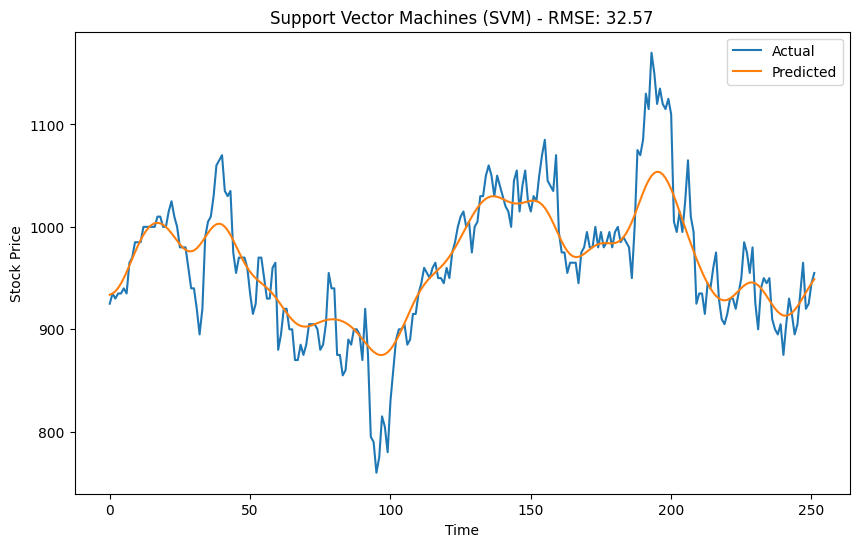

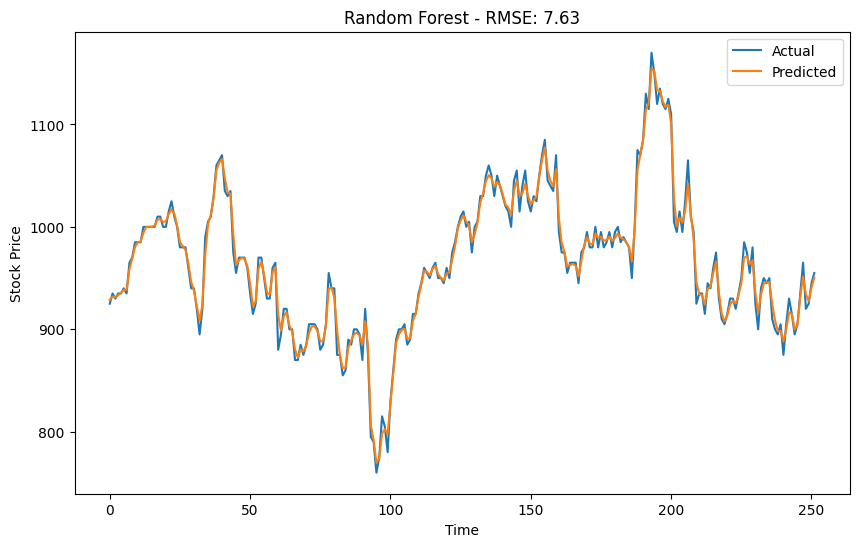

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function untuk menghitung RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# List model dan hasil prediksi tiap model
model_names = ['Support Vector Machines (SVM)', 'Random Forest']
predictions = [svm_predictions, rf_predictions]
best_models = [svm_best_model, rf_best_model]

# Memotong data actual yang disesuaikan dengan jumlah data prediksi
actual_values_reverse = close_price_NCKL_reverse[-len(svm_predictions):]

# Mengevaluasi model dan memvisualisasikannya dalam grafik
for i, model_name in enumerate(model_names):
    model_prediction = predictions[i]
    model_prediction_truncated = model_prediction[-len(actual_values_reverse):]  
    model_rmse = rmse(actual_values_reverse, model_prediction_truncated)

    # Membuat plot actual vs prediksi
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values_reverse, label='Actual')
    plt.plot(model_prediction_truncated, label='Predicted')
    plt.title(f"{model_name} - RMSE: {model_rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

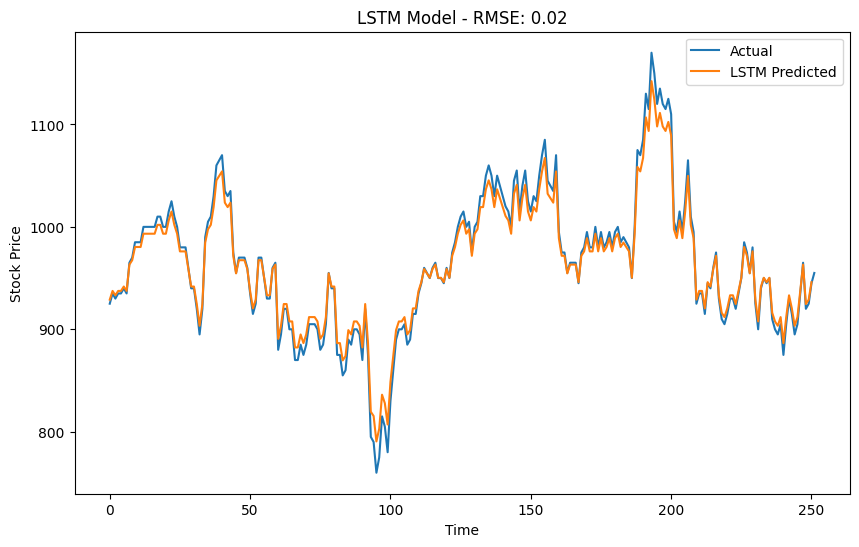

In [14]:
# Membuat plot hasil prediksi dengan model LSTM
plt.figure(figsize=(10, 6))
plt.plot(actual_values_reverse, label='Actual')
plt.plot(all_lstm_predictions, label='LSTM Predicted')
plt.title(f"LSTM Model - RMSE: {best_rmse:.2f}")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


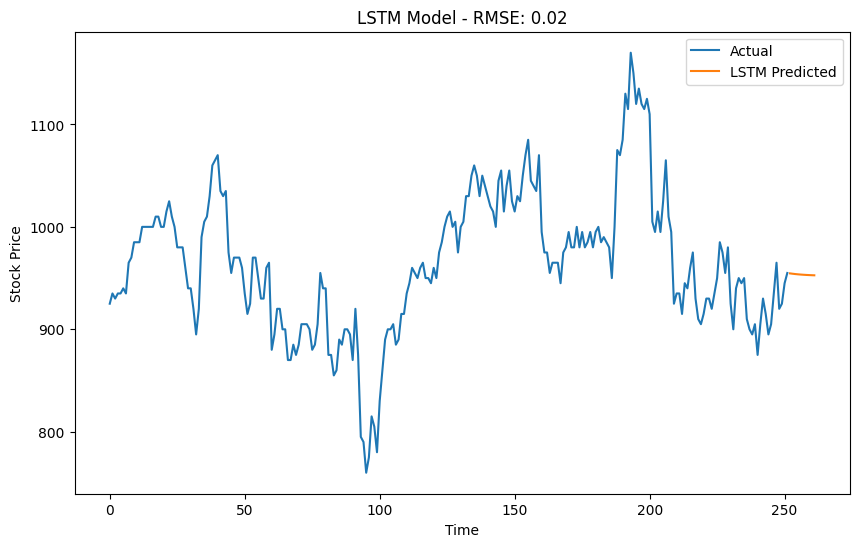

Prediksi harga saham NCKL 10 hari kedepan:
Day 1: 954.58
Day 2: 954.23
Day 3: 953.92
Day 4: 953.66
Day 5: 953.44
Day 6: 953.24
Day 7: 953.08
Day 8: 952.94
Day 9: 952.82
Day 10: 952.71


In [15]:
# Function untuk prediksi harga saham NCKL dengan model LSTM (model dengan RMSE terendah)

scaling_factor = np.max(close_price_NCKL_reverse)
def predict_future_lstm(model, data, num_predictions, scaling_factor):
    predictions = []

    # data terakhir pada dataset
    last_data_point = data[-1]

    for _ in range(num_predictions):
        # Predict the next time step
        prediction = model.predict(last_data_point.reshape(1, 1, 1))
        predictions.append(prediction[0, 0])

        last_data_point = np.append(last_data_point[1:], prediction)

    # Normalisasi data prediksi
    predictions = np.array(predictions) * scaling_factor

    return predictions

# Prediksi harga saham 10 hari kedepan

num_predictions = 10
lstm_predictions = predict_future_lstm(best_lstm_model, data_normalized, num_predictions, scaling_factor)

# Plot data prediksi harga saham 10 hari kedepan
plt.figure(figsize=(10, 6))
plt.plot(close_price_NCKL_reverse, label='Actual')
plt.plot(np.arange(len(close_price_NCKL_reverse), len(close_price_NCKL_reverse) + num_predictions), lstm_predictions, label='LSTM Predicted')
plt.title(f"LSTM Model - RMSE: {best_rmse:.2f}")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Hasil prediksi data harga saham NCKL 10 hari kedepan
print("Prediksi harga saham NCKL 10 hari kedepan:")
for i, prediction in enumerate(lstm_predictions, start=1):
    print(f"Day {i}: {prediction:.2f}")